<a href="https://colab.research.google.com/github/SandeepUpadhyaya/Machine-Learning-Projects/blob/main/Olist(CLustering_%26_RFM_analysis)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying potential customer based from Brazilian E-Commerce Public Dataset

From the above said dataset there were 8 different CSV files was found pertaining customer data, order data, order items, order payments, order reviews, product data, seller data and category name.

COlab version

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Products

In [3]:
path1 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_products_dataset.csv"
products = pd.read_csv(path1)
path2 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/product_category_name_translation.csv"
prod_cat_name_tr = pd.read_csv(path2)
products = products.merge(prod_cat_name_tr, on='product_category_name', how='left')
products.drop ('product_category_name', axis=1, inplace=True)
products.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [4]:
products.isnull().sum()

product_id                         0
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

Product name, description and category is missing for more than 600 products, the size details of 2 products is missing we can impute dimension details with the median value or we can drop those 2 row

In [5]:
products=products.rename(columns={'product_name_lenght':'product_name_len','product_description_lenght':'product_description_len'})

In [6]:
products[products['product_weight_g'].isnull()]

,product_id,product_name_len,product_description_len,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
8578,09ff539a621711667c43eba6a3bd8466,60.0,865.0,3.0,NaN,NaN,NaN,NaN,baby
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
products = products[~(products['product_weight_g'].isnull())]

Lets check the rows where the product name is missing

In [8]:
products[products['product_name_len'].isnull()].head()

,product_id,product_name_len,product_description_len,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,650.0,17.0,14.0,12.0,NaN
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,300.0,16.0,7.0,20.0,NaN
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,200.0,20.0,20.0,20.0,NaN
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,18500.0,41.0,30.0,41.0,NaN
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,300.0,35.0,7.0,12.0,NaN


No useful information can be gathered with just dimension and product id. We need to know what that product is. Lets drop these 610 rows

In [9]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32949 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32949 non-null  object 
 1   product_name_len               32340 non-null  float64
 2   product_description_len        32340 non-null  float64
 3   product_photos_qty             32340 non-null  float64
 4   product_weight_g               32949 non-null  float64
 5   product_length_cm              32949 non-null  float64
 6   product_height_cm              32949 non-null  float64
 7   product_width_cm               32949 non-null  float64
 8   product_category_name_english  32327 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


# Order

In [10]:
path3 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_order_items_dataset.csv"
o_items = pd.read_csv(path3)
o_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
o_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [12]:
path4 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_orders_dataset.csv"
orders = pd.read_csv(path4,parse_dates = ['order_purchase_timestamp'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [13]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
orders['order_approved_at'] = orders['order_approved_at'].fillna(orders['order_purchase_timestamp'])
orders['order_delivered_carrier_date'] = orders['order_delivered_carrier_date'].fillna(orders['order_approved_at'])
orders['order_delivered_customer_date'] = orders['order_delivered_customer_date'].fillna(orders['order_estimated_delivery_date'])

In [15]:
orders.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

All the missing values were taken care off.

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  object        
 5   order_delivered_carrier_date   99441 non-null  object        
 6   order_delivered_customer_date  99441 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


In [17]:
path5 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_order_reviews_dataset.csv"
o_reviews = pd.read_csv(path5)
o_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [18]:
o_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [19]:
path6 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_order_payments_dataset.csv"
o_payments = pd.read_csv(path6)
o_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [20]:
o_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


# Geolocation

In [21]:
path7 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_geolocation_dataset.csv"
geoloc = pd.read_csv(path7)
geoloc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [22]:
geoloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


# Seller

In [23]:
path8 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_sellers_dataset.csv"
sellers = pd.read_csv(path8)
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [24]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


# Customer

In [25]:
path9 = "/content/drive/MyDrive/Colab Notebooks/Olist/Olist-drive/olist_customers_dataset.csv"
customers = pd.read_csv(path9)
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [26]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


# Merging datasets to one(olist)

In [27]:
olist = orders.merge(o_items, on='order_id', how='left')
olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [28]:
olist.shape

(113425, 14)

In [29]:
olist = olist.merge(o_payments, on='order_id', how='outer', validate='m:m')
olist.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [30]:
olist.shape

(118434, 18)

In [31]:
olist = olist.merge(o_reviews, on='order_id', how='outer')

In [32]:
olist.shape

(119143, 24)

In [33]:
olist = olist.merge(products, on='product_id', how='outer')
olist.shape

(119143, 32)

In [34]:
olist = olist.merge(customers, on='customer_id', how='outer')
olist.shape

(119143, 36)

In [35]:
olist = olist.merge(sellers, on='seller_id', how='outer')
olist.shape

(119143, 39)

In [36]:
olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_len,product_description_len,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [37]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              119143 non-null  object        
 5   order_delivered_carrier_date   119143 non-null  object        
 6   order_delivered_customer_date  119143 non-null  object        
 7   order_estimated_delivery_date  119143 non-null  object        
 8   order_item_id                  118310 non-null  float64       
 9   product_id                     118310 non-null  object        
 10  seller_id                      118310 non-null  object        
 11  

# <font color='red'> check this

In [38]:
olist['total_payment'] = olist['payment_value']*olist['payment_installments']
olist.total_payment.head()
pay_compare = olist[['order_id','price','total_payment']]
pay_compare.head(20)

,order_id,price,total_payment
0,e481f51cbdc54678b7cc49136f2d6af7,29.99,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,29.99,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,29.99,18.59
3,128e10d95713541c87cd1a2e48201934,29.99,113.31
4,0e7e841ddf8f8f2de2bad69267ecfbcf,29.99,37.77
5,bfc39df4f36c3693ff3b63fcbea9e90a,29.99,44.09
6,8736140c61ea584cb4250074756d8f3b,75.90,83.69
7,88407c8c6e12493ff6e845df39540112,75.90,167.38
8,4f2acff0b7d2bcc4a408abe5a223d407,75.90,90.18
9,019aaee09698daf81dcffe9d94a18b5c,75.90,167.38


In [39]:
olist.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
order_id,119143,99441,895ab968e7bb0d5659d16cd74cd1650c,63,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,119143,99441,270c23a11d024a44c896d1894b261a83,63,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,119143,8,delivered,115723,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp,119143,98875,2017-08-08 20:26:31,63,2016-09-04 21:15:19,2018-10-17 17:30:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_approved_at,119143,90893,2017-08-08 20:43:31,63,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_carrier_date,119143,82794,2017-08-10 11:58:14,63,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_customer_date,119143,96088,2017-08-14 12:46:18,63,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_estimated_delivery_date,119143,459,2017-12-20 00:00:00,663,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,118310,NaN,NaN,NaN,NaT,NaT,1.19654,0.699489,1,1,1,1,21
product_id,118310,32951,aca2eb7d00ea1a7b8ebd4e68314663af,536,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis based on customer 

In [40]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [41]:
customers.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,99441,99441,e73b0f49d0f8244b5fc363b88584ec43,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_zip_code_prefix,99441,NaN,NaN,NaN,35137.5,29797.9,1003,11347,24416,58900,99990
customer_city,99441,4119,sao paulo,15540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_state,99441,27,SP,41746,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
cust1 = customers[['customer_id', 'customer_unique_id']]
cust1.head()

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066


In [43]:
cust1.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

Majority of the customer made single purchase.

In [44]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  object        
 5   order_delivered_carrier_date   99441 non-null  object        
 6   order_delivered_customer_date  99441 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


In [45]:
orders.describe(include='all').T

,count,unique,top,freq,first,last
order_id,99441,99441,74dd410abd613e48dcee781aeb269181,1,NaT,NaT
customer_id,99441,99441,b34c248b00a925d02d3d4a1c5877e482,1,NaT,NaT
order_status,99441,8,delivered,96478,NaT,NaT
order_purchase_timestamp,99441,98875,2018-03-31 15:08:21,3,2016-09-04 21:15:19,2018-10-17 17:30:18
order_approved_at,99441,90893,2018-02-27 04:31:10,9,NaT,NaT
order_delivered_carrier_date,99441,82794,2018-05-09 15:48:00,47,NaT,NaT
order_delivered_customer_date,99441,96088,2018-02-06 00:00:00,20,NaT,NaT
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522,NaT,NaT


Filter orders by order_status. Here we will exclude orders with 'canceled' as order_status. We have to consider fraud in real live situation. Since we don't have much information about the status in this dataset, we are going to be inclusive about the orders.

We will use order_purchase_timestamp as date

In [46]:
orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [47]:
orders = orders[orders.order_status != 'canceled']
orders['date'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.date

In [48]:
order1 = orders[['order_id', 'customer_id','date']]
order1.head()

,order_id,customer_id,date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13


In [49]:
o_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [50]:
o_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [51]:
o_items.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,112650,98666,8272b63d03f5f79c56e9e4120aec44ef,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,112650,NaN,NaN,NaN,1.19783,0.705124,1,1,1,1,21
product_id,112650,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,112650,3095,6560211a19b47992c3666cc44a7e94c0,2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shipping_limit_date,112650,93318,2017-07-21 18:25:23,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,112650,NaN,NaN,NaN,120.654,183.634,0.85,39.9,74.99,134.9,6735
freight_value,112650,NaN,NaN,NaN,19.9903,15.8064,0,13.08,16.26,21.15,409.68


In [52]:
o_items['order_id'].nunique()

98666

In [53]:
orderTrans = o_items.groupby(['order_id']).agg({'price':'sum'}).reset_index()
orderTrans.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [54]:
orderTrans.rename(columns={'price':'revenue'}, inplace = True)
orderTrans.head()

,order_id,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


Combine Orders dataset with OrderItems dataset to get the revenue of each orders

In [55]:
orderDetails = pd.merge(order1, orderTrans, on = 'order_id', how = 'left')
orderDetails

,order_id,customer_id,date,revenue
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13,19.90
...,...,...,...,...
98811,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09,72.00
98812,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06,174.90
98813,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27,205.99
98814,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08,359.98


In [56]:
orderCusDetails_raw = pd.merge(cust1, orderDetails, on = 'customer_id', how = 'left')
orderCusDetails_raw

,customer_id,customer_unique_id,order_id,date,revenue
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,230.00
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07,74.90
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04,114.90
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08,37.00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03,689.00


In [57]:
# extracting based on customer_unique_id
orderCusDetails_raw[orderCusDetails_raw['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_id,customer_unique_id,order_id,date,revenue
28432,6152d0774bbbf74f7140541c0569dafa,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,2017-01-05,10.9
35693,588047d7101d88c333691e47659d7099,12f5d6e1cbf93dafd9dcc19095df0b3d,ca5a215980675471f0cf8199c041909a,2017-01-05,10.9
71569,c0352e94059e3e5a714c9ad0c8306a54,12f5d6e1cbf93dafd9dcc19095df0b3d,17fed53ba6dfef9b594ee2268642e2aa,2017-01-05,9.9
89230,27129ce1ebca4ffa23a049c51cc8ec95,12f5d6e1cbf93dafd9dcc19095df0b3d,464de32dc84484c1d26df3e8e38e708b,2017-01-05,6.9
97034,ed1793d2d1e4175d5846ce7ebb4a01f5,12f5d6e1cbf93dafd9dcc19095df0b3d,747996a66f5aa711deb8ae58f5ae46a0,2017-01-05,9.9
98493,a969b9f8d923bc7fd97b578f7c499194,12f5d6e1cbf93dafd9dcc19095df0b3d,8a784d47854e4cbc5562362393d504db,2017-01-05,9.9


From this we can extract purchases made by desired customer based on unique_customer_id. 

In [58]:
# extracting based on customer_id
orderCusDetails_raw[orderCusDetails_raw['customer_id'] == '6152d0774bbbf74f7140541c0569dafa']

,customer_id,customer_unique_id,order_id,date,revenue
28432,6152d0774bbbf74f7140541c0569dafa,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,2017-01-05,10.9


Also we can extract the information details based on customer_id also.

In [59]:
orderCusDetails = orderCusDetails_raw.groupby(['customer_unique_id','date']).agg({'revenue':'sum'}).reset_index()
orderCusDetails

,customer_unique_id,date,revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00
...,...,...,...
97872,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,1570.00
97873,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,64.89
97874,ffff371b4d645b6ecea244b27531430a,2017-02-07,89.90
97875,ffff5962728ec6157033ef9805bacc48,2018-05-02,115.00


In [60]:
# Testing
orderCusDetails[orderCusDetails['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_unique_id,date,revenue
7299,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05,58.4


# Identifying customer based on revenue

In [61]:
# extracting customer_unique_id based on revenue
threshold =1000
orderCusDetails[(orderCusDetails.revenue > threshold)]

,customer_unique_id,date,revenue
135,005226be8d5b972d0f72b4e8a79f322b,2018-04-01,1561.0
264,00adeda9b742746c0c66e10d00ea1b74,2017-11-07,2078.5
297,00c07da5ba0e07b4f248a3a373b07476,2018-07-27,2258.0
428,011875f0176909c5cf0b14a9138bb691,2017-03-18,3999.9
451,0129d48dce554d95f641d01eaa88904a,2018-03-15,1390.0
...,...,...,...
97586,ff4159b92c40ebe40454e3e6a7c35ed6,2017-05-24,6499.0
97655,ff6c9c45f6cee4ec0785650b18322d73,2018-07-18,1499.0
97778,ffba9f9dff87b05e310ecc46c8591044,2017-02-27,1591.2
97864,fff5eb4918b2bf4b2da476788d42051c,2018-07-02,1050.0


extracting customer_unique_id based on some threshold limit example considering only customer who's revenue is greater than $100

In [62]:
orderCusDetails['customer_unique_id'].nunique()

95560

In [63]:
# making copy of the dataframe
df = orderCusDetails.copy()

In [64]:
# Getting the older and newer purchase date
print('Older purchase date:{}, Latest purchase date:{}'.format(min(df['date']),max(df['date'])))
lastDate = max(df['date']) + dt.timedelta(1)
print(lastDate)

Older purchase date:2016-09-04, Latest purchase date:2018-09-03
2018-09-04


# <font color='red'>Sorting the customer based on Duration

In [65]:
df1 = df.groupby('customer_unique_id') .agg({'date': lambda x:(lastDate - x.min()).days}).reset_index()
df1.rename(columns = {'date':'Duration'}, inplace = True)
df1

,customer_unique_id,Duration
0,0000366f3b9a7992bf8c76cfdf3221e2,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120
2,0000f46a3911fa3c0805444483337064,543
3,0000f6ccb0745a6a4b88665a16c9f078,327
4,0004aac84e0df4da2b147fca70cf8255,294
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453
95556,fffea47cd6d3cc0a88bd621562a9d061,268
95557,ffff371b4d645b6ecea244b27531430a,574
95558,ffff5962728ec6157033ef9805bacc48,125


This analysis tells us how long the customer is involved in the shopping.

In [66]:
test = df1.sort_values(by=['Duration'],ascending=False)
test

,customer_unique_id,Duration
68711,b7d76e111c89f7ebf14761390f0f7d17,730
49038,830d5b7aaa3b6f1e9ad63703bec97d23,719
17772,2f64e403852e6893ae37485d5fcacdaf,701
36687,61db744d2f835035a5625b59350c6b63,701
50608,87776adb449c551e74c13fc34f036105,701
...,...,...
4689,0c6d7218d5f3fa14514fd29865269993,6
45660,7a22d14aa3c3599238509ddca4b93b01,6
47867,7febafa06d9d8f232a900a2937f04338,6
1545,0421e7a23f21e5d54efed456aedbc513,6


Sorting based on number of days the customer actively involved in shopping.

# <font color='red'>Sorting the customer based on Recency

In [67]:
df2 = df.groupby('customer_unique_id').agg({'date': lambda x:(x.max() - x.min()).days}).reset_index()
df2.rename(columns = {'date':'recency'}, inplace = True)
df2

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,0
4,0004aac84e0df4da2b147fca70cf8255,0
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,0
95556,fffea47cd6d3cc0a88bd621562a9d061,0
95557,ffff371b4d645b6ecea244b27531430a,0
95558,ffff5962728ec6157033ef9805bacc48,0


In [68]:
# checking recency 
df2[df2['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_unique_id,recency
7131,12f5d6e1cbf93dafd9dcc19095df0b3d,0


recency can be found for the selecting customer.

In [69]:
# considering the customer who has made more than one purchase.
df2[df2['recency'] != 0]

,customer_unique_id,recency
106,004288347e5e88a27ded2bb23747066c,171
124,004b45ec5c64187465168251cd1c9c2f,267
248,00a39521eb40f7012db50455bf083460,11
412,011575986092c30523ecb71ff10cb473,60
427,011b4adcd54683b480c4d841250a987f,177
...,...,...
95107,fed519569d16e690df6f89cb99d4e682,88
95175,ff03923ad1eb9e32304deb7f9b2a45c9,33
95223,ff22e30958c13ffe219db7d711e8f564,10
95382,ff8892f7c26aa0446da53d01b18df463,186


The above analysis shows the purchase made by the customer more than once.

In [70]:
df2.sort_values(by=['recency'],ascending=False).head(50)

,customer_unique_id,recency
19056,32ea3bdedab835c3aa6cb68ce66565ef,633
76491,ccafc1c3f270410521c3c6f3b249870f,609
81074,d8f3c4f441a9b59a29f977df16724f38,583
55554,94e5ea5a8c1bf546db2739673060c43f,581
50699,87b3f231705783eb2217e25851c0a45d,573
53473,8f6ce2295bdbec03cd50e34b4bd7ba0a,537
18267,30b782a79466007756f170cb5bd6bbd8,525
60407,a1c61f8566347ec44ea37d22854634a1,524
29259,4e23e1826902ec9f208e8cc61329b494,524
60660,a262442e3ab89611b44877c7aaf77468,522


This analysis tells us if recency is higher means Customer actively involved in the purchase. If recency is 0 means customer has made shopping only once.

# <font color='red'>Sorting the customer based on Freequency of purchase

'Frequency' represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

In [71]:
df3 = df.groupby(['customer_unique_id']).agg({'date': 'count'}).reset_index()
df3.rename(columns = {'date':'frequency'},inplace = True)
df3

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,1
95556,fffea47cd6d3cc0a88bd621562a9d061,1
95557,ffff371b4d645b6ecea244b27531430a,1
95558,ffff5962728ec6157033ef9805bacc48,1


In [72]:
df3.frequency.unique()

array([ 1,  2,  3,  4,  7,  5,  6, 17])

In [73]:
df3.frequency.value_counts()

1     93468
2      1936
3       123
4        19
6         6
5         5
7         2
17        1
Name: frequency, dtype: int64

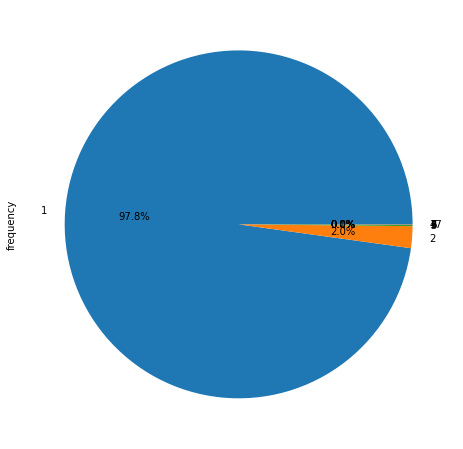

In [74]:
plt.figure(figsize=(15,8))
df3.frequency.value_counts().plot(kind='pie',autopct='%1.1f%%');

In [75]:
df3.sort_values(by=['frequency'],ascending=False)

,customer_unique_id,frequency
52676,8d50f5eadf50201ccdcedfb9e2ac8455,17
75650,ca77025e7201e3b30c44b472ff346268,7
10291,1b6c7548a2a1f9037c1fd3ddfed95f33,7
23342,3e43e6105506432c953e165fb2acf44c,6
37598,6469f99c1f9dfae7733b25662e7f1782,6
...,...,...
32209,56018f90d636604006ef92df10174bc0,1
32208,560046dc7dd7b822bb2f7f1e5e33a2c8,1
32207,55ff07e0b97b4b60d2e22b2efbc35ae0,1
32206,55fe382ae8056da66b8558080f08da46,1


This analysis shows customer based on freequency of purchase.

# <font color = 'red'>Sorting the customer based on average value of a given customer's purchase(Monetary value).

In [76]:
df4 = df.groupby(['customer_unique_id']).agg({'revenue':'sum'}).reset_index()
df4.rename(columns ={'revenue':'total_monetary'},inplace = True)
df4

,customer_unique_id,total_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,64.89
95557,ffff371b4d645b6ecea244b27531430a,89.90
95558,ffff5962728ec6157033ef9805bacc48,115.00


In [77]:
df4.sort_values(by=['total_monetary'],ascending=False).head(10)

,customer_unique_id,total_monetary
3809,0a0a92112bd4c708ca5fde585afaa872,13440.0
81497,da122df9eeddfedc1dc1f5349a1a690c,7388.0
44205,763c8b1c9c68a0229c42c9fc6f662b93,7160.0
82340,dc4802a71eae9be1dd28f5d788ceb526,6735.0
26063,459bef486812aa25204be022145caa62,6729.0
95272,ff4159b92c40ebe40454e3e6a7c35ed6,6499.0
23989,4007669dec559734d6f53e029e360987,5934.6
89189,eebb5dda148d3893cdaf5b5ca3040ccb,4690.0
27293,48e1ac109decbb87765a3eade6854098,4590.0
60575,a229eba70ec1c2abef51f04987deb7a5,4400.0


This tells us total_monetary value of first 10 customer. The maximum total_monetary value is $1344 made by a individual customer.

In [78]:
#meging freequency to the dataframe
df5 =pd.merge(df3, df4, on = 'customer_unique_id', how ='left')
df5

,customer_unique_id,frequency,total_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,1,64.89
95557,ffff371b4d645b6ecea244b27531430a,1,89.90
95558,ffff5962728ec6157033ef9805bacc48,1,115.00


In [79]:
# Finding average monetary value of customer
df5['avg_monetary'] = df5['total_monetary'] / df5['frequency']
df5['frequency'] = df5['frequency'] - 1
df5 = df5.drop(columns=['total_monetary'])
df5

,customer_unique_id,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,18.90
2,0000f46a3911fa3c0805444483337064,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,0,180.00
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,0,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,0,64.89
95557,ffff371b4d645b6ecea244b27531430a,0,89.90
95558,ffff5962728ec6157033ef9805bacc48,0,115.00


In [80]:
# Let us consider only customer with freequency of purchase>0
df5[df5['frequency'] != 0]

,customer_unique_id,frequency,avg_monetary
106,004288347e5e88a27ded2bb23747066c,1,158.945000
124,004b45ec5c64187465168251cd1c9c2f,1,43.450000
248,00a39521eb40f7012db50455bf083460,1,40.725000
412,011575986092c30523ecb71ff10cb473,1,91.450000
427,011b4adcd54683b480c4d841250a987f,1,91.715000
...,...,...,...
95107,fed519569d16e690df6f89cb99d4e682,1,124.950000
95175,ff03923ad1eb9e32304deb7f9b2a45c9,1,110.320000
95223,ff22e30958c13ffe219db7d711e8f564,1,145.000000
95382,ff8892f7c26aa0446da53d01b18df463,1,138.975000


In [81]:
# checking
df5[df5['customer_unique_id'] == '02168ea18740a0fdaaa15f11bebba5db']

,customer_unique_id,frequency,avg_monetary
779,02168ea18740a0fdaaa15f11bebba5db,1,99.8


Analysis like frequency and avg_monetary can be found for individual selected customer.

In [82]:
df_combined1 = pd.merge(df1,df2, on = 'customer_unique_id', how = 'outer')
df_combined1

,customer_unique_id,Duration,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0
2,0000f46a3911fa3c0805444483337064,543,0
3,0000f6ccb0745a6a4b88665a16c9f078,327,0
4,0004aac84e0df4da2b147fca70cf8255,294,0
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453,0
95556,fffea47cd6d3cc0a88bd621562a9d061,268,0
95557,ffff371b4d645b6ecea244b27531430a,574,0
95558,ffff5962728ec6157033ef9805bacc48,125,0


In [83]:
df_combined2 = pd.merge(df_combined1, df5, on = 'customer_unique_id', how = 'outer')
df_combined2

,customer_unique_id,Duration,recency,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0,0,18.90
2,0000f46a3911fa3c0805444483337064,543,0,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,0,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,0,0,180.00
...,...,...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453,0,0,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,268,0,0,64.89
95557,ffff371b4d645b6ecea244b27531430a,574,0,0,89.90
95558,ffff5962728ec6157033ef9805bacc48,125,0,0,115.00


All the four metrics Duration,recency,frequency and avg_monetary value are comined. These four metrics can be used to analyze the porential customer in terms of number of purchase,purchasing history and monetary value.

In [84]:
df_combined2[df_combined2['customer_unique_id'] == 'ff922bdd6bafcdf99cb90d7f39cea5b3']

,customer_unique_id,Duration,recency,frequency,avg_monetary
95400,ff922bdd6bafcdf99cb90d7f39cea5b3,559,204,2,31.596667


In [85]:
# Testing
df_combined2[df_combined2['recency'] != 0]

,customer_unique_id,Duration,recency,frequency,avg_monetary
106,004288347e5e88a27ded2bb23747066c,404,171,1,158.945000
124,004b45ec5c64187465168251cd1c9c2f,368,267,1,43.450000
248,00a39521eb40f7012db50455bf083460,104,11,1,40.725000
412,011575986092c30523ecb71ff10cb473,199,60,1,91.450000
427,011b4adcd54683b480c4d841250a987f,378,177,1,91.715000
...,...,...,...,...,...
95107,fed519569d16e690df6f89cb99d4e682,258,88,1,124.950000
95175,ff03923ad1eb9e32304deb7f9b2a45c9,134,33,1,110.320000
95223,ff22e30958c13ffe219db7d711e8f564,11,10,1,145.000000
95382,ff8892f7c26aa0446da53d01b18df463,468,186,1,138.975000


In [86]:
# extracting customer_unique_id based on avg_monetary
threshold =1000
df_combined2[(df_combined2.avg_monetary > threshold)]

,customer_unique_id,Duration,recency,frequency,avg_monetary
133,005226be8d5b972d0f72b4e8a79f322b,156,0,0,1561.0
261,00adeda9b742746c0c66e10d00ea1b74,301,0,0,2078.5
294,00c07da5ba0e07b4f248a3a373b07476,39,0,0,2258.0
424,011875f0176909c5cf0b14a9138bb691,535,0,0,3999.9
445,0129d48dce554d95f641d01eaa88904a,173,0,0,1390.0
...,...,...,...,...,...
95272,ff4159b92c40ebe40454e3e6a7c35ed6,468,0,0,6499.0
95341,ff6c9c45f6cee4ec0785650b18322d73,48,0,0,1499.0
95461,ffba9f9dff87b05e310ecc46c8591044,554,0,0,1591.2
95547,fff5eb4918b2bf4b2da476788d42051c,64,0,0,1050.0


# Outlier Analysis, Scaling and Clustering

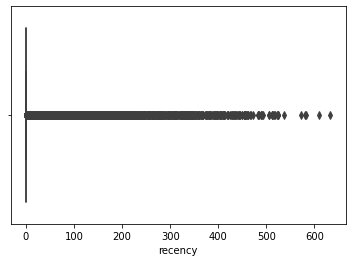

In [87]:
sns.boxplot(df_combined2['recency']);

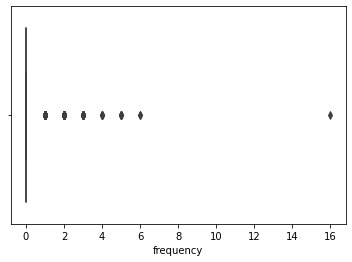

In [88]:
sns.boxplot(df_combined2['frequency']);

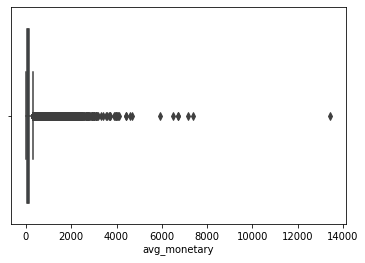

In [89]:
sns.boxplot(df_combined2['avg_monetary']);

In [90]:
rfm_df = df_combined2.copy()
rfm_df.head()

,customer_unique_id,Duration,recency,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0,0,18.90
2,0000f46a3911fa3c0805444483337064,543,0,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,0,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,0,0,180.00


In [91]:
# Let us consider scaling before clustering
rfm_df_scaled = rfm_df[['avg_monetary', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df_scaled)
rfm_df_scaled.shape

(95560, 3)

In [92]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['monetary', 'frequency', 'recency']
rfm_df_scaled.head()

,monetary,frequency,recency
0,-0.038864,-0.134601,-0.106454
1,-0.562935,-0.134601,-0.106454
2,-0.326395,-0.134601,-0.106454
3,-0.529460,-0.134601,-0.106454
4,0.197676,-0.134601,-0.106454


# K-Means Clustering

# Finding the Optimal Number of Clusters

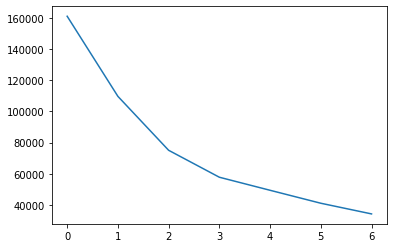

In [93]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

# Silhouette Analysis

In [94]:
# # silhouette analysis
# range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# for num_clusters in range_n_clusters:
    
#     # intialise kmeans
#     kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
#     kmeans.fit(rfm_df_scaled)
    
#     cluster_labels = kmeans.labels_
    
#     # silhouette score
#     silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
#     print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For 2 cluster=2 the Silhouette score found was 90.94
For 3 clusters i.e cluster=3 Silhouette score found was 85.4
We can decide number of cluster 2 or 3. Let us go with 3 cluster

In [95]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [96]:
# assign the label
rfm_df['cluster_id'] = kmeans.labels_
rfm_df.head()

,customer_unique_id,Duration,recency,frequency,avg_monetary,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0,0,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0,0,18.90,0
2,0000f46a3911fa3c0805444483337064,543,0,0,69.00,0
3,0000f6ccb0745a6a4b88665a16c9f078,327,0,0,25.99,0
4,0004aac84e0df4da2b147fca70cf8255,294,0,0,180.00,0


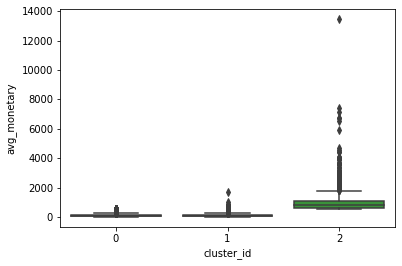

In [97]:
# plot
sns.boxplot(x='cluster_id', y='avg_monetary', data=rfm_df);

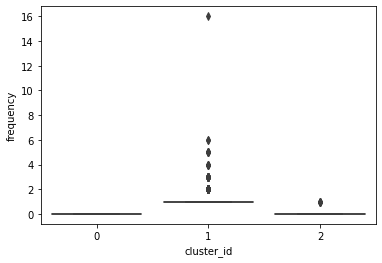

In [98]:
# plot
sns.boxplot(x='cluster_id', y='frequency', data=rfm_df);

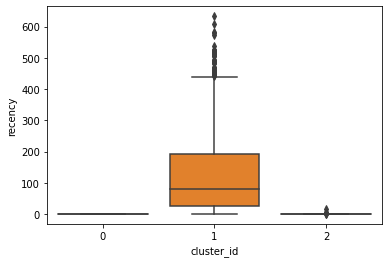

In [99]:
# plot
sns.boxplot(x='cluster_id', y='recency', data=rfm_df);

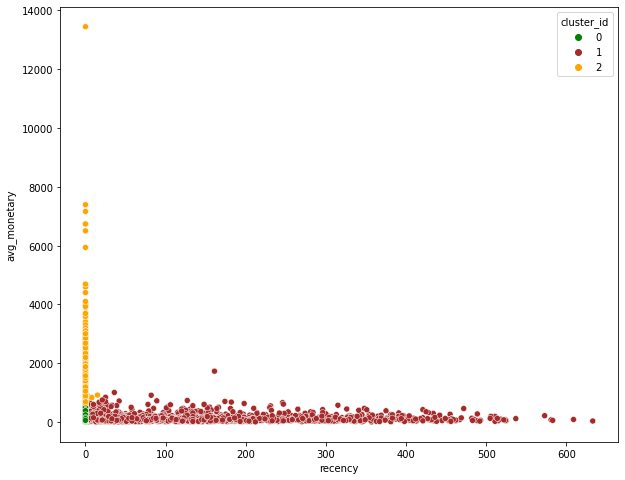

In [100]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="recency", y="avg_monetary", hue="cluster_id",data=rfm_df, palette=['green','brown','orange']);

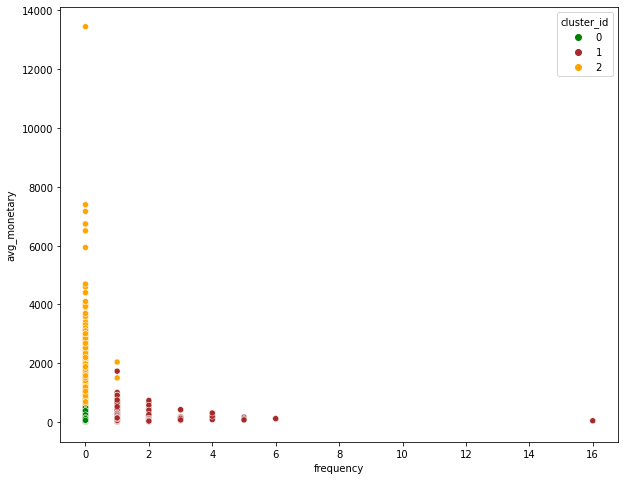

In [101]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="frequency", y="avg_monetary", hue="cluster_id",data=rfm_df, palette=['green','brown','orange']);

In [102]:
rfm_df.head()

,customer_unique_id,Duration,recency,frequency,avg_monetary,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0,0,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0,0,18.90,0
2,0000f46a3911fa3c0805444483337064,543,0,0,69.00,0
3,0000f6ccb0745a6a4b88665a16c9f078,327,0,0,25.99,0
4,0004aac84e0df4da2b147fca70cf8255,294,0,0,180.00,0


In [103]:
new_df = rfm_df.copy()

In [104]:
rfm_df_scaled.head()

,monetary,frequency,recency
0,-0.038864,-0.134601,-0.106454
1,-0.562935,-0.134601,-0.106454
2,-0.326395,-0.134601,-0.106454
3,-0.529460,-0.134601,-0.106454
4,0.197676,-0.134601,-0.106454


# Recency Clustering analysis

In [105]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_df_scaled[['recency']])
rfm_df_scaled['RecencyCluster'] = kmeans.predict(rfm_df_scaled[['recency']])

In [106]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

rfm_df_scaled = order_cluster('RecencyCluster','recency',rfm_df_scaled,True)

In [107]:
rfm_df_scaled.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,94452.0,-0.095003,0.139818,-0.106454,-0.106454,-0.106454,-0.106454,2.771135
1,756.0,5.656910,1.917288,2.810554,3.953706,5.491048,7.195921,9.472370
2,352.0,13.342713,3.032290,9.551208,10.999857,12.685020,15.000888,24.845790


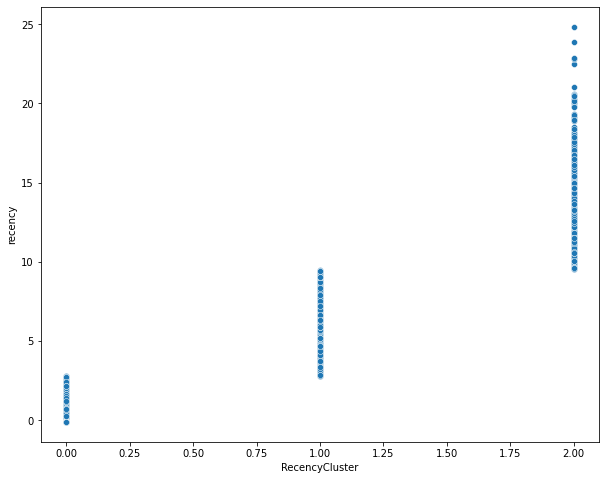

In [108]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="RecencyCluster",y="recency",data=rfm_df_scaled);

# Freequency Clustering analysis

In [109]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_df_scaled[['frequency']])
rfm_df_scaled['FrequencyCluster'] = kmeans.predict(rfm_df_scaled[['frequency']])

#order the frequency cluster
rfm_df_scaled= order_cluster('FrequencyCluster', 'frequency',rfm_df_scaled,True)

#see details of each cluster
rfm_df_scaled.groupby('FrequencyCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,93468.0,-0.134601,2.923233e-13,-0.134601,-0.134601,-0.134601,-0.134601,-0.134601
1,1936.0,5.416763,8.706397e-14,5.416763,5.416763,5.416763,5.416763,5.416763
2,156.0,13.423539,7.599632e+00,10.968127,10.968127,10.968127,10.968127,88.687230


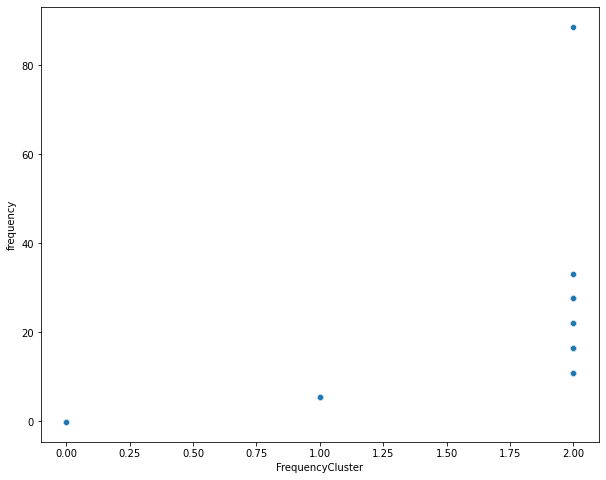

In [110]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="FrequencyCluster",y="frequency",data=rfm_df_scaled);

# Monetary Clustering analysis

In [111]:
#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_df_scaled[['monetary']])
rfm_df_scaled['MonetaryCluster'] = kmeans.predict(rfm_df_scaled[['monetary']])


#order the cluster numbers
rfm_df_scaled = order_cluster('MonetaryCluster', 'monetary',rfm_df_scaled,True)

#show details of the dataframe
rfm_df_scaled.groupby('MonetaryCluster')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,86552.0,-0.219908,0.293599,-0.652169,-0.453871,-0.283902,-0.043113,0.669812
1,8182.0,1.587412,0.882423,0.670285,0.905408,1.231654,2.086173,4.420367
2,826.0,7.318765,3.920667,4.446429,5.070156,6.139509,8.271203,62.802917


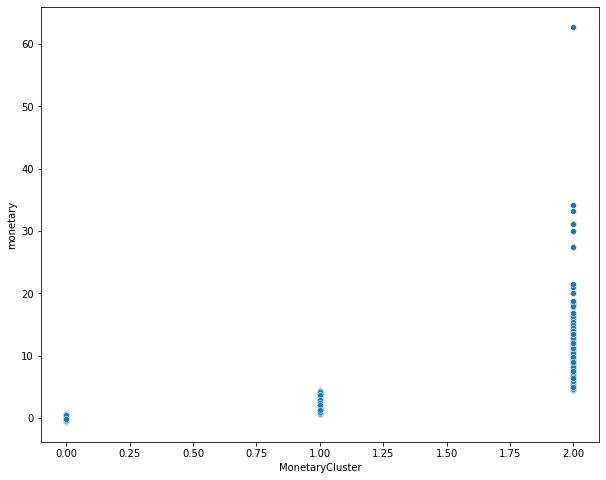

In [112]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="MonetaryCluster",y="monetary",data=rfm_df_scaled);

# Overall Score

In [113]:
#calculate overall score and use mean() to see details
rfm_df_scaled['OverallScore'] = rfm_df_scaled['RecencyCluster'] + rfm_df_scaled['FrequencyCluster'] + rfm_df_scaled['MonetaryCluster']
rfm_df_scaled.groupby('OverallScore')['recency','frequency','monetary'].mean()

,recency,frequency,monetary
OverallScore,,,
0,-0.106454,-0.134601,-0.220900
1,0.002817,0.413120,1.415455
2,2.299544,2.600236,3.848809
3,11.020122,6.669379,0.076969
4,13.174726,12.605068,0.352703
5,12.562821,12.078400,1.595005


In [114]:
rfm_df_scaled_final= pd.concat([rfm_df.customer_unique_id,rfm_df_scaled],axis=1)
rfm_df_scaled_final.head()

,customer_unique_id,monetary,frequency,recency,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.038864,-0.134601,-0.106454,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.562935,-0.134601,-0.106454,0,0,0,0
2,0000f46a3911fa3c0805444483337064,-0.326395,-0.134601,-0.106454,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,-0.529460,-0.134601,-0.106454,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0.197676,-0.134601,-0.106454,0,0,0,0


In [115]:
rfm_df_scaled_final['OverallScore'] = rfm_df_scaled['RecencyCluster'] + rfm_df_scaled['FrequencyCluster'] + rfm_df_scaled['MonetaryCluster']
rfm_df_scaled_final.head()

,customer_unique_id,monetary,frequency,recency,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.038864,-0.134601,-0.106454,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.562935,-0.134601,-0.106454,0,0,0,0
2,0000f46a3911fa3c0805444483337064,-0.326395,-0.134601,-0.106454,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,-0.529460,-0.134601,-0.106454,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0.197676,-0.134601,-0.106454,0,0,0,0


In [116]:
rfm_df_scaled_final['Segment'] = 'Low-Value'
rfm_df_scaled_final.loc[rfm_df_scaled_final['OverallScore']>2,'Segment'] = 'Mid-Value' 
rfm_df_scaled_final.loc[rfm_df_scaled_final['OverallScore']>4,'Segment'] = 'High-Value' 

In [117]:
rfm_df_scaled_final.head(10)

,customer_unique_id,monetary,frequency,recency,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.038864,-0.134601,-0.106454,0,0,0,0,Low-Value
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.562935,-0.134601,-0.106454,0,0,0,0,Low-Value
2,0000f46a3911fa3c0805444483337064,-0.326395,-0.134601,-0.106454,0,0,0,0,Low-Value
3,0000f6ccb0745a6a4b88665a16c9f078,-0.529460,-0.134601,-0.106454,0,0,0,0,Low-Value
4,0004aac84e0df4da2b147fca70cf8255,0.197676,-0.134601,-0.106454,0,0,0,0,Low-Value
5,0004bd2a26a76fe21f786e4fbd80607f,0.074921,-0.134601,-0.106454,0,0,0,0,Low-Value
6,00050ab1314c0e55a6ca13cf7181fecf,-0.520018,-0.134601,-0.106454,0,0,0,0,Low-Value
7,00053a61a98854899e70ed204dd4bafe,-0.014785,-0.134601,-0.106454,0,0,0,0,Low-Value
8,0005e1862207bf6ccc02e4228effd9a0,-0.156898,-0.134601,-0.106454,0,0,0,0,Low-Value
9,0005ef4cd20d2893f0d9fbd94d3c0d97,-0.586542,-0.134601,-0.106454,0,0,0,0,Low-Value


In [118]:
rfm_df_scaled_final.tail(20)

,customer_unique_id,monetary,frequency,recency,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
95540,ffef0ffa736c7b3d9af741611089729b,5.367566,-0.134601,-0.106454,0,0,2,2,Low-Value
95541,fff1afc79f6b5db1e235a4a6c30ceda7,5.485128,-0.134601,-0.106454,0,0,2,2,Low-Value
95542,fff1bdd5c5e37ca79dd74deeb91aa5b6,6.132426,-0.134601,-0.106454,0,0,2,2,Low-Value
95543,fff22793223fe80c97a8fd02ac5c6295,12.001078,-0.134601,-0.106454,0,0,2,2,Low-Value
95544,fff2ae16b99c6f3c785f0e052f2a9cfb,4.574330,-0.134601,-0.106454,0,0,2,2,Low-Value
95545,fff3a9369e4b7102fab406a334a678c3,5.230599,-0.134601,-0.106454,0,0,2,2,Low-Value
95546,fff3e1d7bc75f11dc7670619b2e61840,5.953015,-0.134601,-0.106454,0,0,2,2,Low-Value
95547,fff5eb4918b2bf4b2da476788d42051c,5.012048,-0.134601,-0.106454,0,0,2,2,Low-Value
95548,fff699c184bcc967d62fa2c6171765f7,6.897287,-0.134601,-0.106454,0,0,2,2,Low-Value
95549,fff7219c86179ca6441b8f37823ba3d3,8.223989,-0.134601,-0.106454,0,0,2,2,Low-Value


In [119]:
rfm_df_scaled_final.Segment.value_counts()

Low-Value     95087
Mid-Value       468
High-Value        5
Name: Segment, dtype: int64

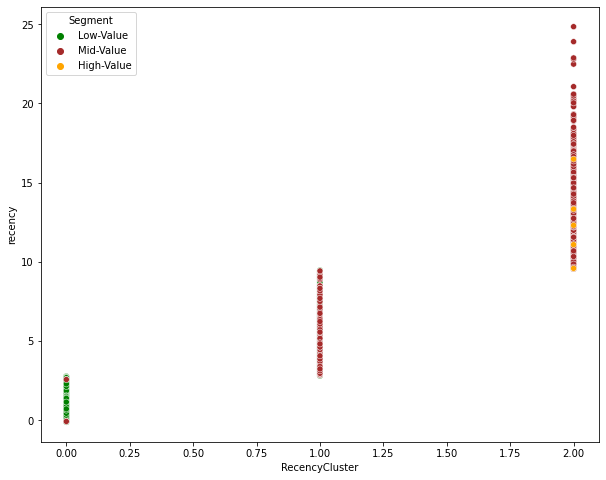

In [120]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(y="recency", x="RecencyCluster", hue="Segment",
              data=rfm_df_scaled_final, 
                    palette=['green','brown','orange']);

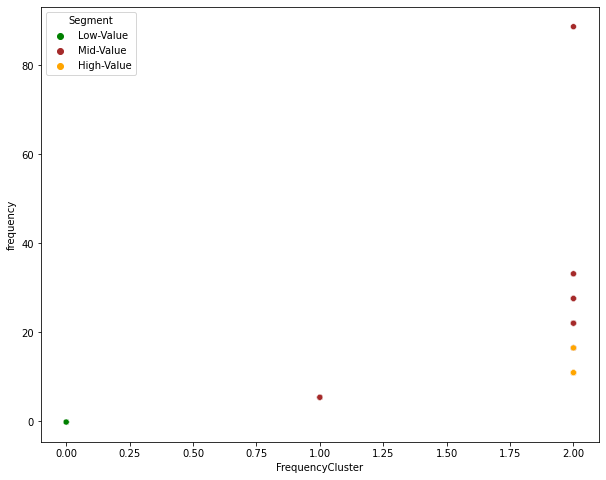

In [121]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(y="frequency", x="FrequencyCluster", hue="Segment",
              data=rfm_df_scaled_final, 
                    palette=['green','brown','orange']);

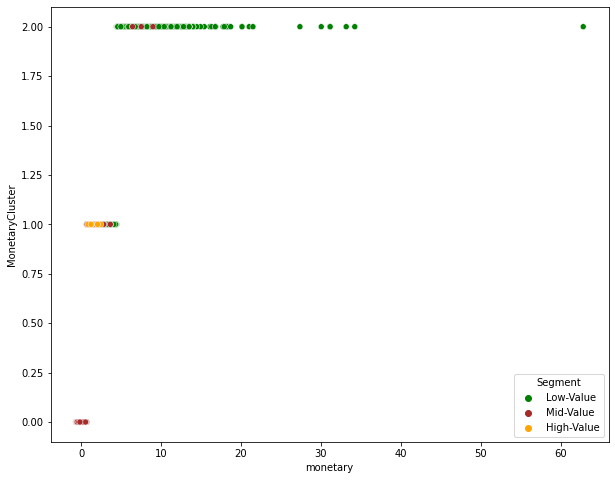

In [122]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="monetary", y="MonetaryCluster",hue="Segment",
              data=rfm_df_scaled_final, 
                    palette=['green','brown','orange']);